In [2]:
import seaborn as sb
import matplotlib.pyplot as plt
import pandas as pd
import sklearn as sk
import numpy as np

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import mean_squared_error
from sklearn import metrics
from sklearn.model_selection import cross_validate, RandomizedSearchCV, RepeatedStratifiedKFold
from sklearn.utils import resample
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from sklearn.inspection import permutation_importance
from scipy.stats import loguniform
from imblearn.over_sampling import RandomOverSampler
from sklearn.metrics import confusion_matrix

## read data 
CIP_data_no_drop = pd.read_csv("CIP_data_encode_prev_not_dropped.csv")


In [ ]:
#𝑈(𝜆,𝑝)=𝜆𝑞(𝑝)−𝑐(𝑝)
#𝑈(𝜆,𝑝)=𝜆𝑞(𝑝)−𝑐(𝑝) =𝜆[𝛼(𝑝)× 𝜇𝐹𝐿𝑄-𝑅+(1−𝜇𝐹𝐿𝑄-𝑅)]−(1−𝛽(𝑝))×(1−𝜇𝐹𝐿𝑄-𝑅).
#𝑝 is the classification threshold (𝑝=0 is equivalent to sensitivity 0% and specificity 100%, and 𝑝=1 is equivalent to sensitivity 100% and specificity 0%),
#𝑞(𝑝) is the expected proportion of individuals with RR-TB who receive effective treatment (i.e., a regiment that is consistent with susceptibility of their M. tuberculosis strain to FLQs) if the classification threshold is set to 𝑝,
#𝑐(𝑝) is the expected proportion of individuals with RR-TB who unnecessarily receive DLM (instead of an FLQ) if the classification threshold is set to 𝑝; and
#𝜆 is a trade-off threshold that represent the policymaker’s willingness to accept an increase in the proportion of individuals who unnecessarily receive DLM (i.e., 𝑐(𝑝)) in order to increase the proportion of individuals who receive effective treatment (i.e., 𝑞(𝑝)).
#sensitivity 𝛼(𝑝) and specificity 𝛽(𝑝)
#mu is the prevalence of resistance


In [ ]:
#SO, what we would have is, for a specific sensitivity and specificity for a particular classificiation threshold. 
#The prevalenece of resistant strains is fixed by year... so we can't change the past, can only say "at each time point, if we had done this, this is what would have happened"
# q_p = proprotion that get effective treatment 
# do we have different lines for different years? or do we just artificially say 'of if the prevalence was this much, and the threshold was this much, this is what the graph would be'? Maybe try that...



In [18]:
## function for getting utility 
def utility(lambda_to, sensitivity, specificity, prevalence):
    lambda_to = 5
    q_p = float(sensitivity*prevalence + (1-prevalence))
    c_p = float((1 - specificity)*(1- prevalence))
    utility_p = -c_p + lambda_to*q_p
    return utility_p, q_p, c_p

In [16]:
threshold_seq = np.linspace(0,1,101)
#for the prevalence, in the TB paper, they used the prevalence to flq in the whole dataset 
#so for us, think that would be 14%
#calculate prevalence of CIP resistance 
prevalence_CIPR = 1 - CIP_data_no_drop["Susceptible"].sum()/len(CIP_data_no_drop["Susceptible"])
print(1 - CIP_data_no_drop["Susceptible"].sum()/len(CIP_data_no_drop["Susceptible"]))

# need to use the threshold to get the senstivity and specificity of the model 
utility_results = []

### set up model 
model_nn = MLPClassifier(solver = 'lbfgs', activation = 'tanh', max_iter = 3000 ,hidden_layer_sizes= 13, alpha = 1.291549665014884, random_state=10, learning_rate = 'constant' )
#train data: 2000 - 2010 
train_data = CIP_data_no_drop.loc[CIP_data_no_drop['YEAR'].isin([2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009,2010])]
X_train = train_data[['MSM','MSMW', 'MSW', 'Oth/Unk/Missing','Northeast', 'Southeast', 'Southwest', 'West', 'Midwest','PREV_REGION', 'PREV_CLINIC']]
y_train = train_data['Susceptible']

oversample = RandomOverSampler(sampling_strategy = 0.5,random_state=42)
X_train, y_train = oversample.fit_resample(X_train,y_train)


#test data: 2011 - 2019 
test_data = CIP_data_no_drop.loc[CIP_data_no_drop['YEAR'].isin([2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019])]
X_test = test_data[['MSM','MSMW', 'MSW', 'Oth/Unk/Missing','Northeast', 'Southeast', 'Southwest', 'West', 'Midwest','PREV_REGION', 'PREV_CLINIC']]
y_test = test_data['Susceptible']
oversample = RandomOverSampler(sampling_strategy = 0.5,random_state=42)
X_test, y_test = oversample.fit_resample(X_test,y_test)

#fit model on training data 
model_fit_train = model_nn.fit(X_train, y_train)

     #2. Test model on test data to get test specificity and sensitivity 
  
y_predict_test = model_fit_train.predict(X_test)
y_predict_proba = model_fit_train.predict_proba(X_test)
 
y_predict_test = np.where(y_predict_proba[:, 1] > threshold, 1, 0)
#loop setup

for threshold in threshold_seq:


    # predicted prevalence = predicted number of cases/total cases? or are we using a specific year? 
    tn_test , fp_test , fn_test , tp_test  = confusion_matrix(y_true=y_test, y_pred=y_predict_test).ravel()
     
    sensitivity  = tp_test  / (tp_test   + fn_test) 
    specificity   = tn_test / (tn_test + fp_test )
    utility_threshold = utility(5, sensitivity, specificity, prevalence =prevalence_CIPR)
    utility_results.append(utility_threshold)


0.14488785370753954


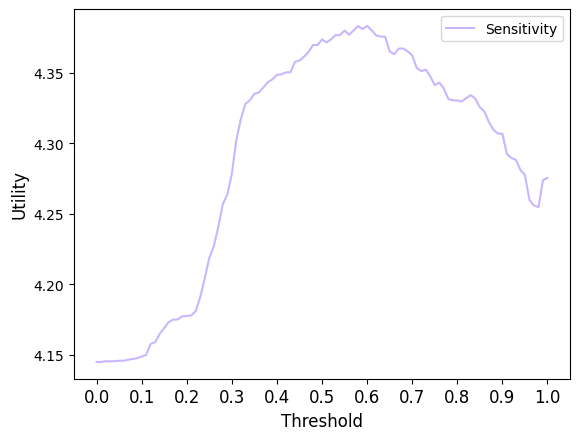

In [17]:
plt.plot(threshold_seq, utility_results, color = "#c8b6ff", label = "Sensitivity")
#plt.errorbar(threshold_seq, specificity_test_table, yerr = y_err_sensitivity, ecolor="lightblue")

plt.xlabel("Threshold", fontsize=12)
plt.ylabel("Utility", fontsize=12)
plt.xticks(np.linspace(0,1,11), fontsize=12)
plt.rcParams['figure.dpi'] = 300
plt.legend()

In [25]:
### try utility only based on 2011 data and dropping features from PI (other and SW)

threshold_seq = np.linspace(0,1,2001)
#for the prevalence, in the TB paper, they used the prevalence to flq in the whole dataset 
#so for us, think that would be 14%
#calculate prevalence of CIP resistance 
prevalence_CIPR = 1 - CIP_data_no_drop["Susceptible"].sum()/len(CIP_data_no_drop["Susceptible"])
print(1 - CIP_data_no_drop["Susceptible"].sum()/len(CIP_data_no_drop["Susceptible"]))

# need to use the threshold to get the senstivity and specificity of the model 
utility_results = []
q_p_results = []
c_p_results = []

### set up model 
model_nn = MLPClassifier(solver = 'lbfgs', activation = 'tanh', max_iter = 3000 ,hidden_layer_sizes= 13, alpha = 1.291549665014884, random_state=10, learning_rate = 'constant' )
#train data: 2000 - 2010 
train_data = CIP_data_no_drop.loc[CIP_data_no_drop['YEAR'].isin([2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009,2010])]
X_train = train_data[['MSM','MSMW', 'MSW','Northeast', 'Southeast', 'West', 'Midwest','PREV_REGION', 'PREV_CLINIC']]
y_train = train_data['Susceptible']

oversample = RandomOverSampler(sampling_strategy = 0.5,random_state=42)
X_train, y_train = oversample.fit_resample(X_train,y_train)


#test data: 2011 - 2019 
test_data = CIP_data_no_drop.loc[CIP_data_no_drop['YEAR'].isin([2011])]
X_test = test_data[['MSM','MSMW', 'MSW','Northeast', 'Southeast', 'West', 'Midwest','PREV_REGION', 'PREV_CLINIC']]
y_test = test_data['Susceptible']
oversample = RandomOverSampler(sampling_strategy = 0.5,random_state=42)
X_test, y_test = oversample.fit_resample(X_test,y_test)

#fit model on training data 
model_fit_train = model_nn.fit(X_train, y_train)

  
y_predict_test = model_fit_train.predict(X_test)
y_predict_proba = model_fit_train.predict_proba(X_test)

for threshold in threshold_seq:
    
    y_predict_test = np.where(y_predict_proba[:, 1] > threshold, 1, 0)

    # predicted prevalence = predicted number of cases/total cases? or are we using a specific year? 
    tn_test , fp_test , fn_test , tp_test  = confusion_matrix(y_true=y_test, y_pred=y_predict_test).ravel()
     
    sensitivity  = tp_test  / (tp_test   + fn_test) 
    specificity   = tn_test / (tn_test + fp_test )
    utility_threshold, q_p, c_p = utility(5, sensitivity, specificity, prevalence =prevalence_CIPR)
    utility_results.append(utility_threshold)
    q_p_results.append(q_p)
    c_p_results.append(c_p)

0.14488785370753954


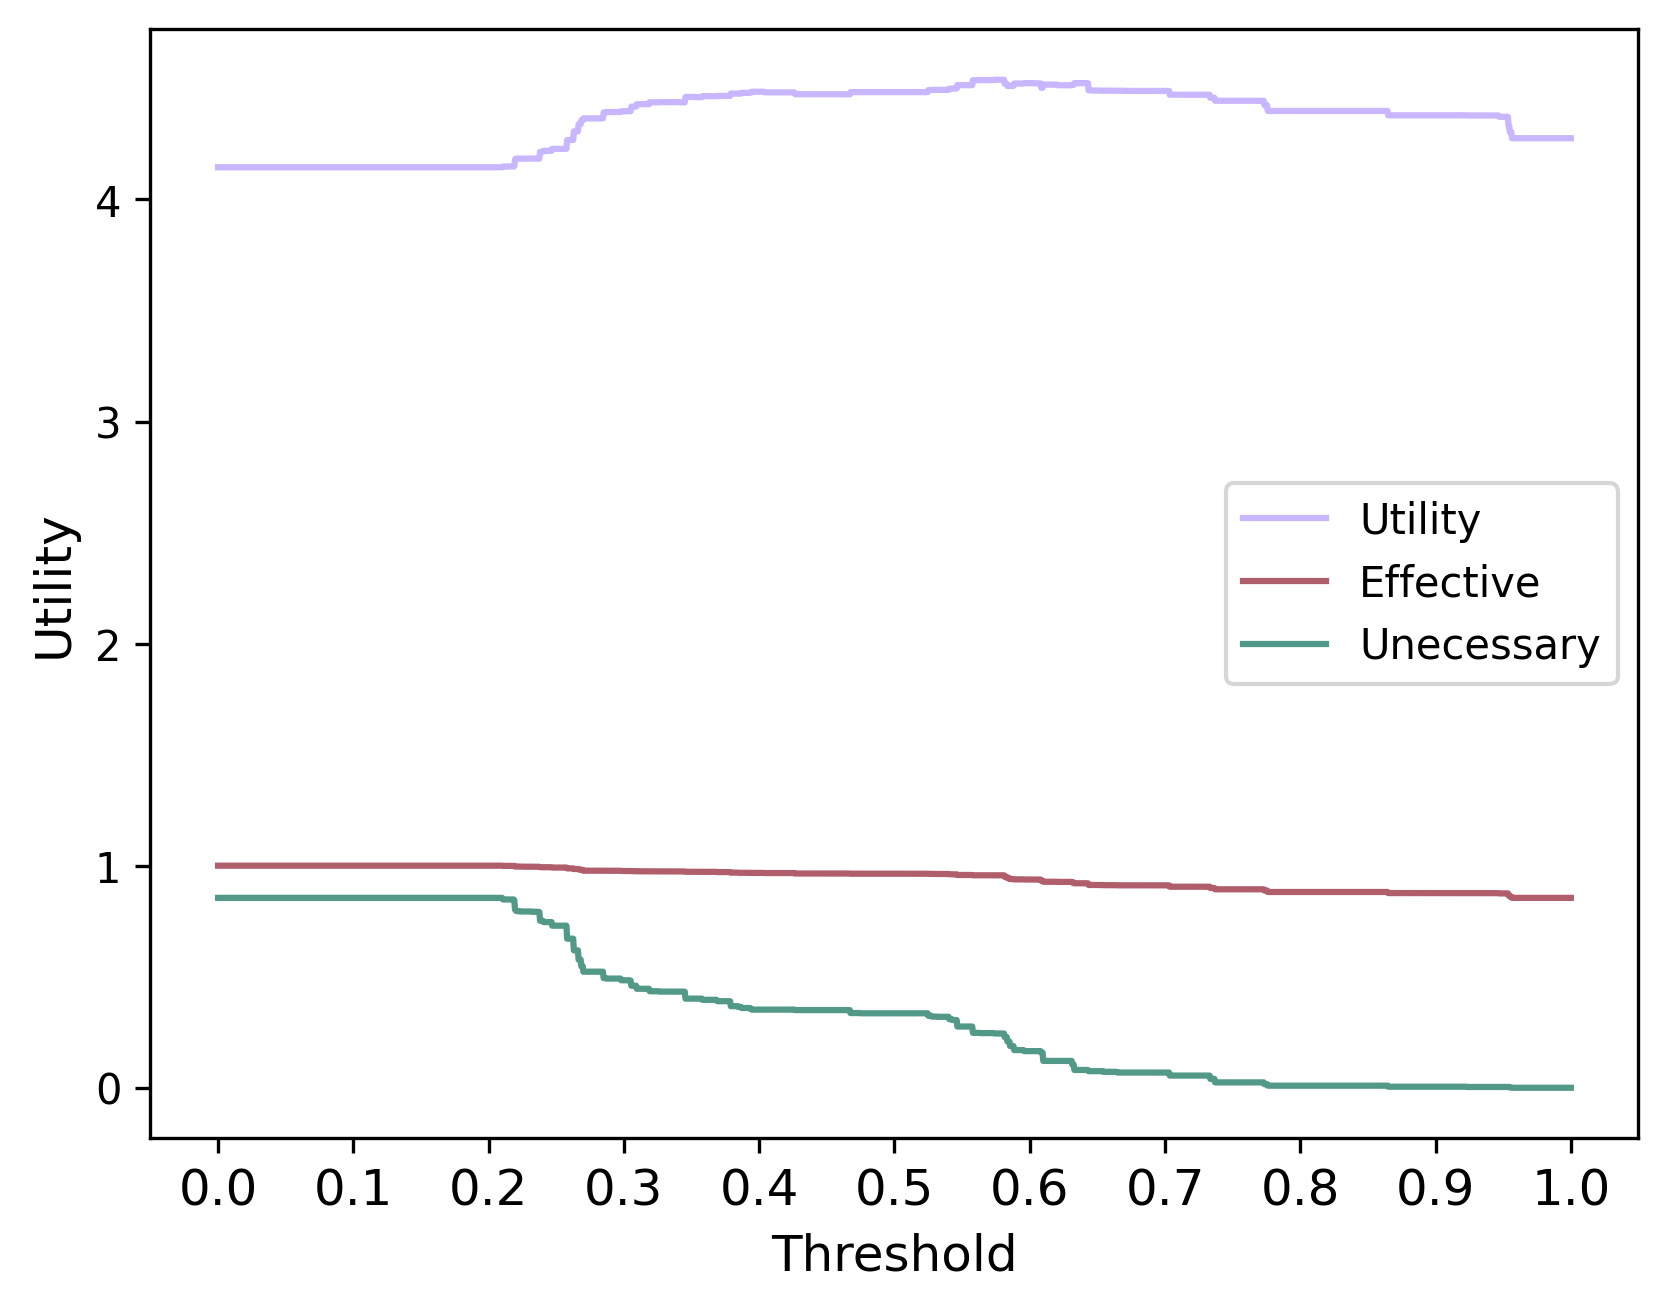

In [31]:
plt.plot(threshold_seq, utility_results, color = "#c8b6ff", label = "Utility")
#plt.errorbar(threshold_seq, specificity_test_table, yerr = y_err_sensitivity, ecolor="lightblue")
plt.plot(threshold_seq, q_p_results, color = "#B15E6C", label = "Effective")
plt.plot(threshold_seq, c_p_results, color = "#539987", label = "Unecessary")

plt.xlabel("Threshold", fontsize=12)
plt.ylabel("Utility", fontsize=12)
plt.xticks(np.linspace(0,1,11), fontsize=12)
plt.rcParams['figure.dpi'] = 300
plt.legend()

In [ ]:
### MEASURING UNECCESARY USAGE 

#Initially, each year investigate how many people were incorrectly prescribed non-cipro drugs because of the blanket policy 
#Do not disaggregate by year 

# get prevalence of resistance by year

years = CIP_data_no_drop["YEAR"].unique()
reistance_by_year_overall = []
reistance_by_year_all = pd.DataFrame() 
for year in years:
    CIP_data_year = CIP_data_no_drop.loc[CIP_data_no_drop['YEAR'] == year]
    reistance_by_year_overall.append(1 - CIP_data_year["Susceptible"].sum()/len(CIP_data_year))

# Get Utility based on the current threshold (which is p - 0, i.e. 100% sensitivity and 0% specificity)

In [44]:
## do we make the simplifying assumption that no-one gets cipro? Even though some, theoretically, could? 

# So from the TB paper:
# receive_effective_regimen = sensitivity * flq_prev + (1 -  flq_prev)
# receive_DML = sflq_prev * sensitivity + (1 - flq_prev) * (1 - specificity) - so this is those that are receiving the new treatment
# for us, under the default, that would be the prevalence of gonohorrea full stop? Because no-one would receive cipro

# receive_unnecessary_DML = (1 - flq_prev) * (1 - specificity)

# assume everyone gets non-cipro treatment
# get susceptible by year
#CIP_data_no_drop.head() #here, susceptible would be those gonohrrea cases that are susceptible to cipro
years = CIP_data_no_drop["YEAR"].unique()
susceptible_to_cipro_by_year_overall = []
reistance_by_year_all = []
for year in years:
    CIP_data_year = CIP_data_no_drop.loc[CIP_data_no_drop['YEAR'] == year]
    susceptible_to_cipro_by_year_overall.append(CIP_data_year["Susceptible"].sum()/len(CIP_data_year))
    reistance_by_year_all.append(1 - CIP_data_year["Susceptible"].sum()/len(CIP_data_year))
print(reistance_by_year_all)


[0.003479216260758089, 0.006946983546617935, 0.02171877925482124, 0.0412071078431373, 0.06761678543151228, 0.09375504276262703, 0.1384691195795007, 0.14827758362456311, 0.13541848680761837, 0.09619487908961588, 0.12462647213921607, 0.1328696925329429, 0.14760080277321652, 0.16026289180990905, 0.19181585677749358, 0.22352024922118385, 0.2679862961553102, 0.30112625963248374, 0.3121241513094083, 0.3542199488491049]
0.1328696925329429


In [ ]:
# so susceptible to cipro is effectively our version of "receive DML" - we assume everyone will be treated
# those unnecessarily getting X will be (1 - ciproR_prev) * (1 - specificity)

#specificity comes from threshold... so would get a result that says 
# "for this threshold, given the data, this is the model specificity and sensitivity. 
# Each year, this is the number of people who unecessarily received X when they could have been on cipro "

In [45]:
# do it for 2011 first with different thresholds

##model
model_nn = MLPClassifier(solver = 'lbfgs', activation = 'tanh', max_iter = 3000 ,hidden_layer_sizes= 13, alpha = 1.291549665014884, random_state=10, learning_rate = 'constant' )

#loop setup
threshold_seq = np.linspace(0,1,101)

#   train - from 2000 to 2010, dropped SW and Other
train_data = CIP_data_no_drop.loc[CIP_data_no_drop['YEAR'].isin([2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010])]
X_train = train_data[['MSM','MSMW', 'MSW','Northeast', 'Southeast',  'West', 'Midwest','PREV_REGION', 'PREV_CLINIC']]
y_train = train_data['Susceptible']

oversample = RandomOverSampler(sampling_strategy = 0.5,random_state=42)
X_train, y_train = oversample.fit_resample(X_train,y_train)

#    test - only look at 2011, dropped SW and Other
test_data = CIP_data_no_drop.loc[CIP_data_no_drop['YEAR'].isin([2011])]
cipro_R_prev_2011 = reistance_by_year_all[11]
X_test = test_data[['MSM','MSMW', 'MSW', 'Northeast', 'Southeast', 'West', 'Midwest','PREV_REGION', 'PREV_CLINIC']]
y_test = test_data['Susceptible']
oversample = RandomOverSampler(sampling_strategy = 0.5,random_state=42)
X_test, y_test = oversample.fit_resample(X_test,y_test)

#      train model 
model_fit_train = model_nn.fit(X_train, y_train)
y_predict_test = model_fit_train.predict(X_test)
y_predict_proba = model_fit_train.predict_proba(X_test)

#dataframes
correctly_get_X_threshold = []
incorrectly_get_X_threshold = [] #no bootstrapping, no 95% CI 

for threshold in threshold_seq:
  print(threshold)

 
  y_predict_test = np.where(y_predict_proba[:, 1] > threshold, 1, 0)

  tn_test , fp_test , fn_test , tp_test  = confusion_matrix(y_true=y_test, y_pred=y_predict_test).ravel()

  sensitivity_test  = tp_test  / (tp_test   + fn_test )
  specificity_test   = tn_test / (tn_test + fp_test )
  
  correctly_get_X_threshold.append(sensitivity_test * cipro_R_prev_2011 + (1 -  cipro_R_prev_2011)) 
  incorrectly_get_X_threshold.append((1 - cipro_R_prev_2011) * (1 - specificity_test))



0.0
0.01
0.02
0.03
0.04
0.05
0.06
0.07
0.08
0.09
0.1
0.11
0.12
0.13
0.14
0.15
0.16
0.17
0.18
0.19
0.2
0.21
0.22
0.23
0.24
0.25
0.26
0.27
0.28
0.29
0.3
0.31
0.32
0.33
0.34
0.35000000000000003
0.36
0.37
0.38
0.39
0.4
0.41000000000000003
0.42
0.43
0.44
0.45
0.46
0.47000000000000003
0.48
0.49
0.5
0.51
0.52
0.53
0.54
0.55
0.56
0.5700000000000001
0.58
0.59
0.6
0.61
0.62
0.63
0.64
0.65
0.66
0.67
0.68
0.6900000000000001
0.7000000000000001
0.71
0.72
0.73
0.74
0.75
0.76
0.77
0.78
0.79
0.8
0.81
0.8200000000000001
0.8300000000000001
0.84
0.85
0.86
0.87
0.88
0.89
0.9
0.91
0.92
0.93
0.9400000000000001
0.9500000000000001
0.96
0.97
0.98
0.99
1.0


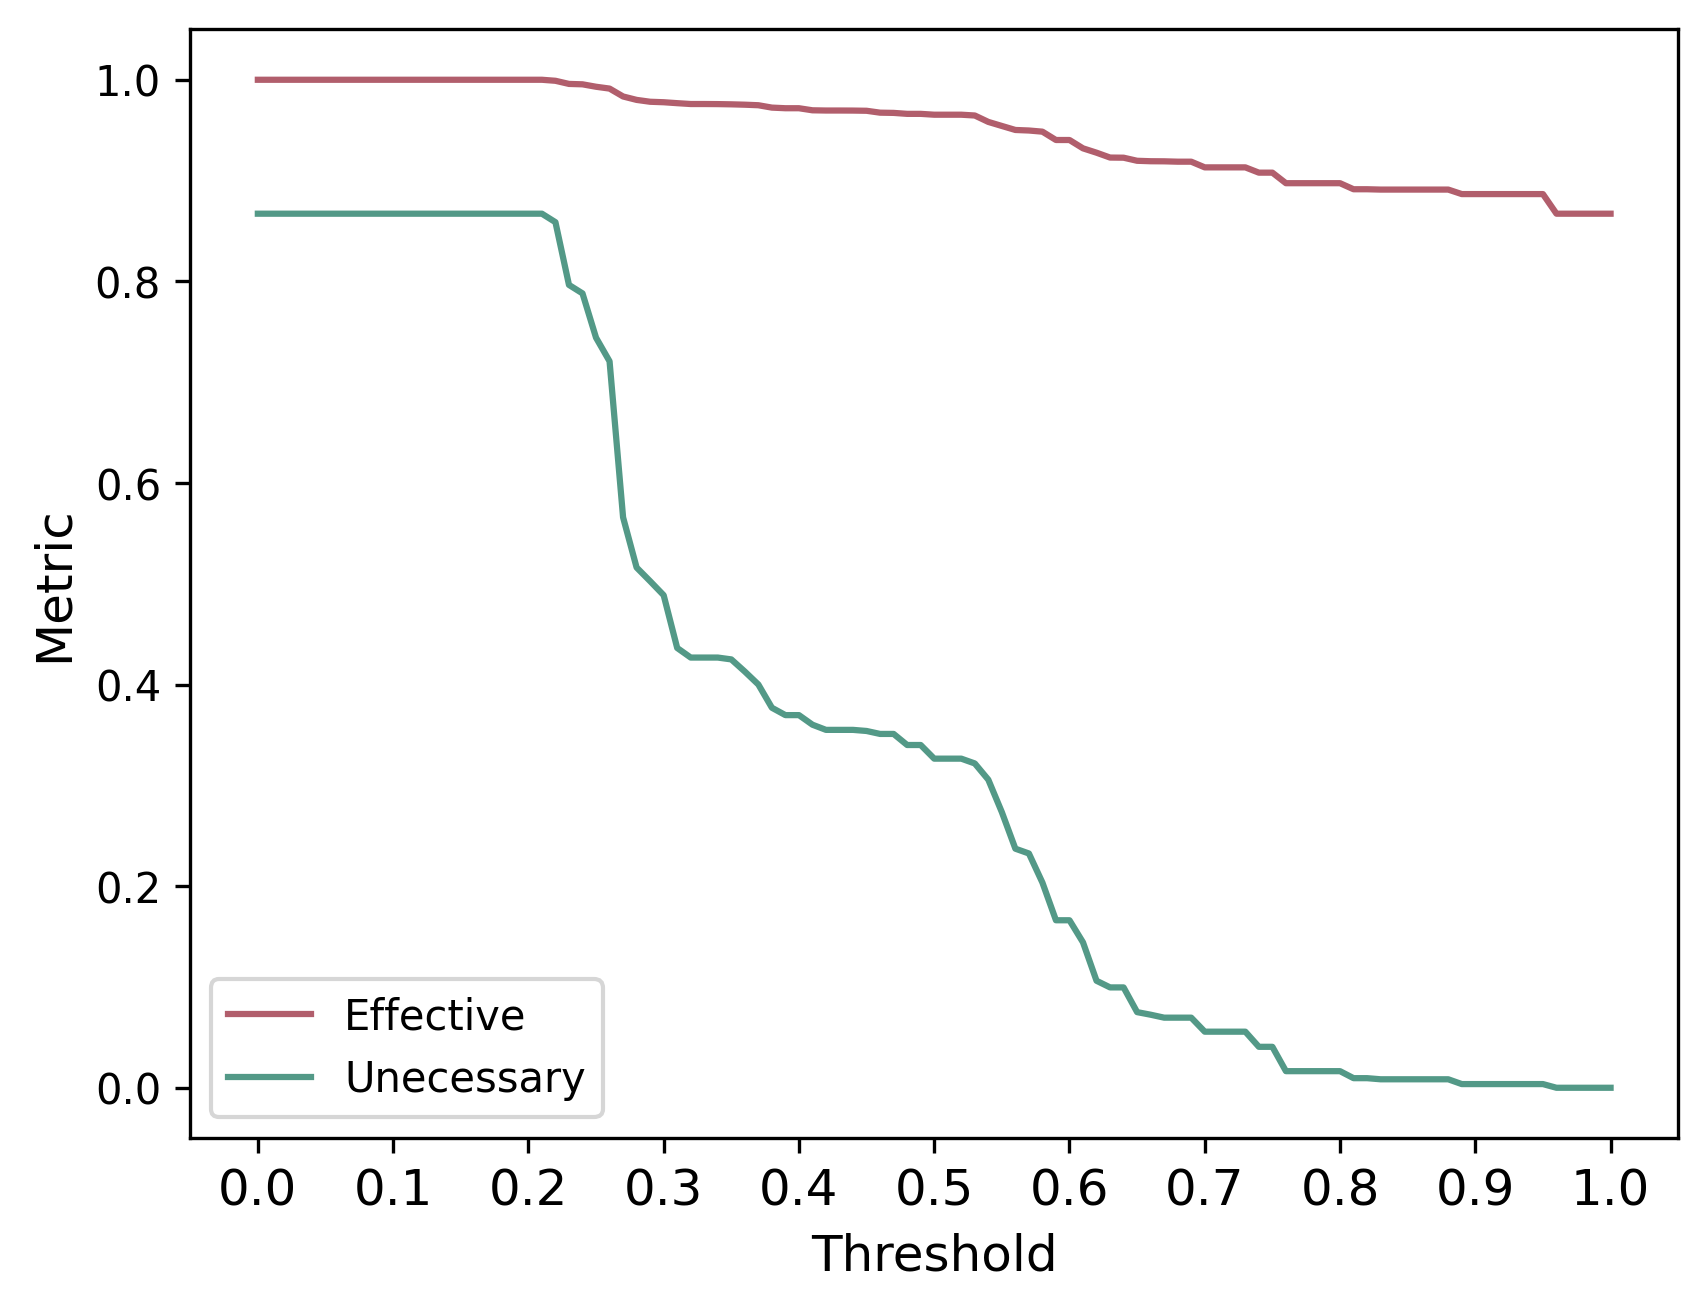

In [46]:
#plt.errorbar(threshold_seq, specificity_test_table, yerr = y_err_sensitivity, ecolor="lightblue")
plt.plot(threshold_seq, correctly_get_X_threshold, color = "#B15E6C", label = "Effective")
plt.plot(threshold_seq, incorrectly_get_X_threshold, color = "#539987", label = "Unecessary")

plt.xlabel("Threshold", fontsize=12)
plt.ylabel("Metric", fontsize=12)
plt.xticks(np.linspace(0,1,11), fontsize=12)
plt.rcParams['figure.dpi'] = 300
plt.legend()

# excess treatment for each threshold in 2011
# the proportion that actually get treatment X in 2011 = prevalence of gonorrhea (as no one gets cipro)
# doesn't work as we don't actually have  that data 
# do it for 2011 first with different thresholds

In [ ]:
#need X = cipro_prevalence_2011
#do not need X = 1 - cipro_prevalence_2011... So this would be a specificity of 0.
# Which is just a rough calculation. So what does the model offer? 

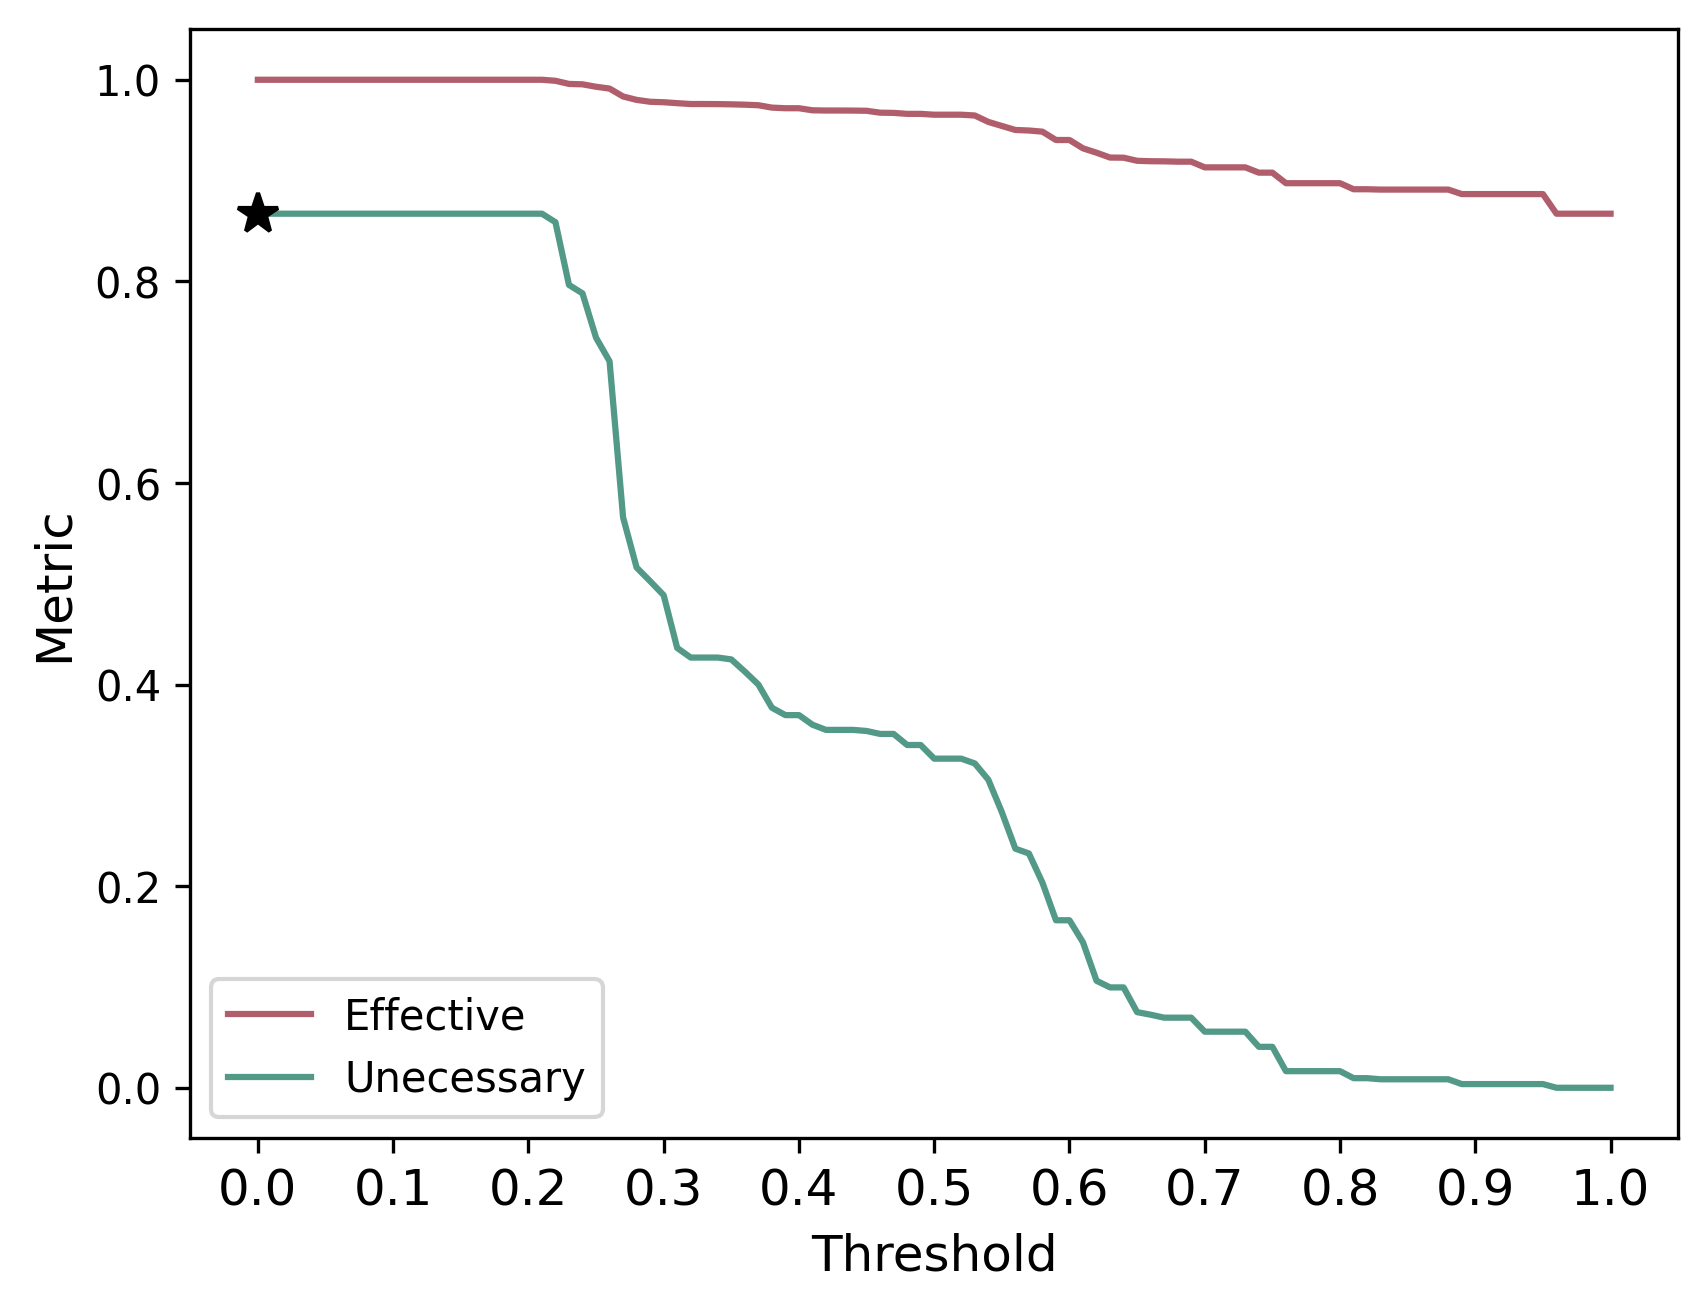

In [51]:
## can we compare the "actual" proprtion that would receive the incorrect treatment with the porpor
#plt.errorbar(threshold_seq, specificity_test_table, yerr = y_err_sensitivity, ecolor="lightblue")
plt.plot(threshold_seq, correctly_get_X_threshold, color = "#B15E6C", label = "Effective")
plt.plot(threshold_seq, incorrectly_get_X_threshold, color = "#539987", label = "Unecessary")

plt.xlabel("Threshold", fontsize=12)
plt.ylabel("Metric", fontsize=12)
plt.xticks(np.linspace(0,1,11), fontsize=12)
plt.rcParams['figure.dpi'] = 300
plt.legend()

plt.plot([0], 1 - cipro_R_prev_2011, marker='*', ls='none', ms=10, color = "black")

#this is only effective in that they are not getting CIPRO - could get another drug they actually cannot have 


In [52]:
# so what is the marginal gain? e.g. at what point is the decrease in the proprotion of people receiving effective treatment worth the decrease in unnecessary cipro? 

#So what would these look like if we just used the 5% prevalence?

##model
model_nn = MLPClassifier(solver = 'lbfgs', activation = 'tanh', max_iter = 3000 ,hidden_layer_sizes= 13, alpha = 1.291549665014884, random_state=10, learning_rate = 'constant' )

#loop setup
threshold_seq = np.linspace(0,1,101)

#   train - from 2000 to 2010, dropped SW and Other
train_data = CIP_data_no_drop.loc[CIP_data_no_drop['YEAR'].isin([2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010])]
X_train = train_data[['MSM','MSMW', 'MSW','Northeast', 'Southeast',  'West', 'Midwest','PREV_REGION', 'PREV_CLINIC']]
y_train = train_data['Susceptible']

oversample = RandomOverSampler(sampling_strategy = 0.5,random_state=42)
X_train, y_train = oversample.fit_resample(X_train,y_train)

#    test - only look at 2011, dropped SW and Other
test_data = CIP_data_no_drop.loc[CIP_data_no_drop['YEAR'].isin([2011])]
cipro_R_prev = 0.05
X_test = test_data[['MSM','MSMW', 'MSW', 'Northeast', 'Southeast', 'West', 'Midwest','PREV_REGION', 'PREV_CLINIC']]
y_test = test_data['Susceptible']
oversample = RandomOverSampler(sampling_strategy = 0.5,random_state=42)
X_test, y_test = oversample.fit_resample(X_test,y_test)

#      train model 
model_fit_train = model_nn.fit(X_train, y_train)
y_predict_test = model_fit_train.predict(X_test)
y_predict_proba = model_fit_train.predict_proba(X_test)

#dataframes
correctly_get_X_threshold_005 = []
incorrectly_get_X_threshold_005 = [] #no bootstrapping, no 95% CI 

for threshold in threshold_seq:
  print(threshold)

 
  y_predict_test = np.where(y_predict_proba[:, 1] > threshold, 1, 0)

  tn_test , fp_test , fn_test , tp_test  = confusion_matrix(y_true=y_test, y_pred=y_predict_test).ravel()

  sensitivity_test  = tp_test  / (tp_test   + fn_test )
  specificity_test   = tn_test / (tn_test + fp_test )
  
  correctly_get_X_threshold_005.append(sensitivity_test * cipro_R_prev + (1 -  cipro_R_prev)) 
  incorrectly_get_X_threshold_005.append((1 - cipro_R_prev) * (1 - specificity_test))

0.0
0.01
0.02
0.03
0.04
0.05
0.06
0.07
0.08
0.09
0.1
0.11
0.12
0.13
0.14
0.15
0.16
0.17
0.18
0.19
0.2
0.21
0.22
0.23
0.24
0.25
0.26
0.27
0.28
0.29
0.3
0.31
0.32
0.33
0.34
0.35000000000000003
0.36
0.37
0.38
0.39
0.4
0.41000000000000003
0.42
0.43
0.44
0.45
0.46
0.47000000000000003
0.48
0.49
0.5
0.51
0.52
0.53
0.54
0.55
0.56
0.5700000000000001
0.58
0.59
0.6
0.61
0.62
0.63
0.64
0.65
0.66
0.67
0.68
0.6900000000000001
0.7000000000000001
0.71
0.72
0.73
0.74
0.75
0.76
0.77
0.78
0.79
0.8
0.81
0.8200000000000001
0.8300000000000001
0.84
0.85
0.86
0.87
0.88
0.89
0.9
0.91
0.92
0.93
0.9400000000000001
0.9500000000000001
0.96
0.97
0.98
0.99
1.0


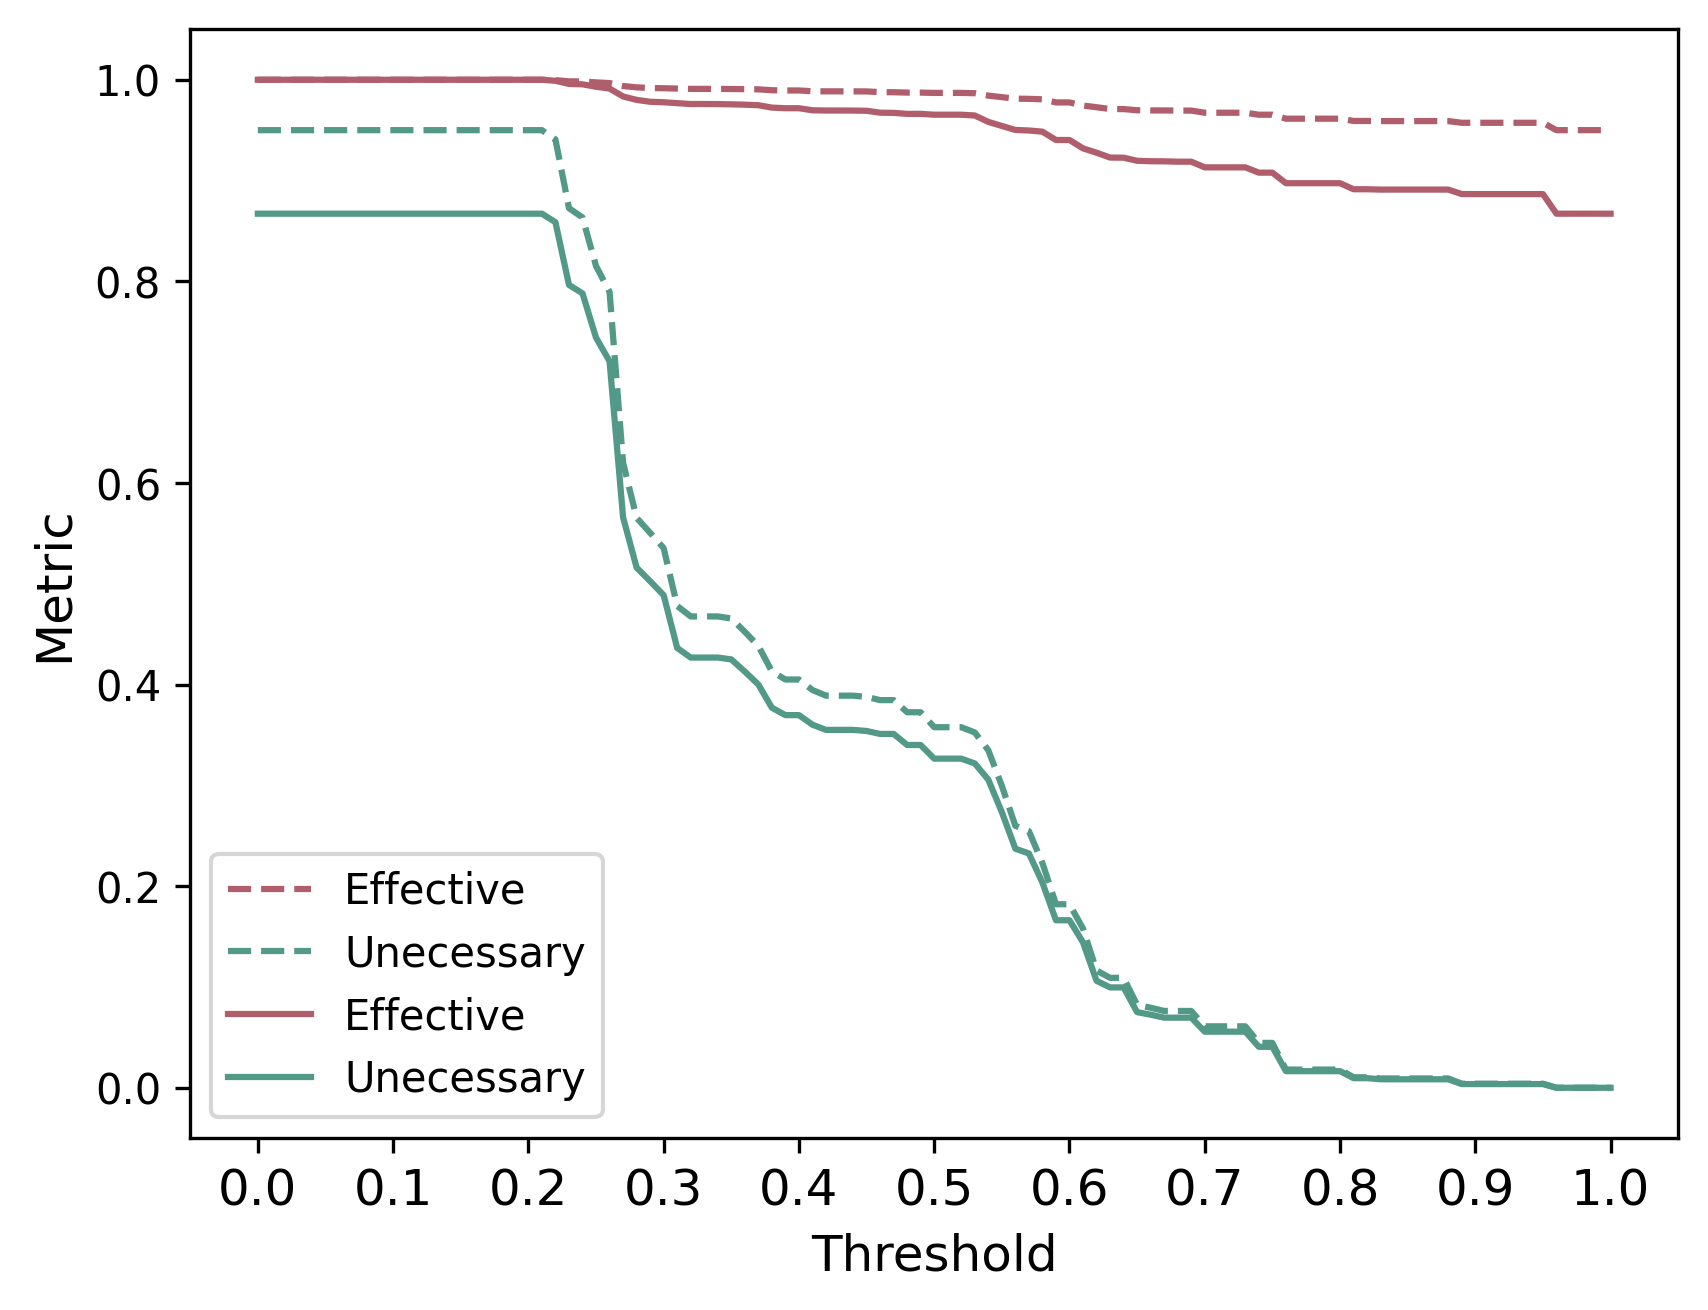

In [59]:
plt.plot(threshold_seq, correctly_get_X_threshold_005, color = "#B15E6C", label = "Effective", linestyle = 'dashed')
plt.plot(threshold_seq, incorrectly_get_X_threshold_005, color = "#539987", label = "Unecessary",linestyle = 'dashed')
plt.plot(threshold_seq, correctly_get_X_threshold, color = "#B15E6C", label = "Effective")
plt.plot(threshold_seq, incorrectly_get_X_threshold, color = "#539987", label = "Unecessary")

plt.xlabel("Threshold", fontsize=12)
plt.ylabel("Metric", fontsize=12)
plt.xticks(np.linspace(0,1,11), fontsize=12)
plt.rcParams['figure.dpi'] = 300
plt.legend()

#looks like 
# so if you have a higher switch threshold, for a model of this sensitivity (i.e. trained on the 2011 data), you 
# have fewer people getting unecessary treatment BUT everyone is getting appropriate treatment? 
plt.savefig('Effective_ineffective_treatment_2011_data_vs_5_pc_threshold.png')

<Figure size 1920x1440 with 0 Axes>